In [1]:
# data set schema
import pandas as pd
from pathlib import Path
from utils import Timer
import os, sys

file = "/mnt/DP_disk1/ht/datasets/autofe/nyc_taxi/train.csv"
cols = [
    'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
]
with Timer(f"Read dataset"):
    train_data = pd.read_csv(file, usecols=cols)
train_data

Read dataset took 50.91403805650771 sec


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
55423851,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
55423852,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
55423853,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
55423854,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [2]:
import pandas as pd
from utils import Timer

def cutomizedCoordinationFix(df):
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    df = df.drop(columns=['rev'])
    return df

def clean_df(df):    
    #reverse incorrectly assigned longitude/latitude values
    df = cutomizedCoordinationFix(df)
    df = df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]
    
    return df

with Timer(f"clean dataset"):
    train_data = clean_df(train_data)

clean dataset took 5.934798208996654 sec


In [4]:
from pyrecdp.autofe import AutoFE

pipeline = AutoFE(dataset=train_data, label="fare_amount")
pipeline.fit_transform(engine_type = "spark", spark_master="spark://sr262:7077")

AutoFE started to profile data


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/pyrecdp/core/dataframe.py:19: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'may_sample' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def may_sample(df, nrows = 100000):
TypeConvertFeatureGenerator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 747.58it/s]


AutoFE started to create data pipeline


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/pyrecdp/core/dataframe.py:19: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'may_sample' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def may_sample(df, nrows = 100000):
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.39it/s]


Feature List generated, using analyzed feature tags to create data pipeline


DropUselessFeatureGenerator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 559.38it/s]


AutoFE started to execute data
per core memory size is 0.000 GB and shuffle_disk maximum capacity is 8589934592.000 GB
execute with spark started ...
append DataFrame
append type_infer
append DataFrameToRDDConverter
DataframeConvert partition pandas dataframe to spark RDD took 19.999 secs
append tuple
append tuple
append astype
append fillna
append astype
append datetime_feature
append haversine
append drop
append DataFrame
append lightgbm
append RDDToDataFrameConverter


DataframeTransform took 36.734 secs, processed 54315955 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 1.627 secs


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.590660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 48884360, number of used features: 11
[LightGBM] [Info] Start training from score 11.324366
[100]	valid_0's rmse: 5.44951
execute with spark took 112.79103031009436 sec


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime__day,pickup_datetime__month,pickup_datetime__weekday,pickup_datetime__year,pickup_datetime__hour,haversine_pickup_coordinates_dropoff_coordinates
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,6,0,2009,17,0.640488
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,1,1,2010,16,5.250677
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,8,3,2011,0,0.863412
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,5,2012,4,1.739388
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,3,1,2010,7,1.242220
...,...,...,...,...,...,...,...,...,...,...,...,...
55423851,14.0,-74.005272,40.740027,-73.963280,40.762555,1,15,3,5,2014,3,2.693273
55423852,4.2,-73.957784,40.765530,-73.951640,40.773959,1,24,3,1,2009,20,0.665235
55423853,14.1,-73.970505,40.752325,-73.960537,40.797342,1,2,4,5,2011,22,3.153803
55423854,28.9,-73.980901,40.764629,-73.870605,40.773963,1,26,10,2,2011,5,5.807441


In [5]:
from utils import Timer
import pandas as pd
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import numpy as np

transformed_data = pipeline.get_transformed_data()
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':2000,
        'num_boost_round': 2000,
        'early_stopping_rounds': 50
    }

with Timer("split data"):
    test_sample = transformed_data.sample(frac = 0.1)
    train_sample = transformed_data.drop(test_sample.index)

with Timer("prepare train and validate for lgbm"):
    x_train = train_sample.drop(columns=['fare_amount'])
    y_train = train_sample['fare_amount'].values

    x_val = test_sample.drop(columns=['fare_amount'])
    y_val = test_sample['fare_amount'].values

    lgbm_train = lgbm.Dataset(x_train, y_train, silent=False)
    lgbm_val = lgbm.Dataset(x_val, y_val, silent=False)

with Timer("train"):
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val, verbose_eval=100)

split data took 9.592570891603827 sec
prepare train and validate for lgbm took 1.2545650359243155 sec


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of L

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.383894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25092
[LightGBM] [Info] Number of data points in the train set: 48884359, number of used features: 11


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.323794
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.92684
[200]	valid_0's rmse: 3.81032
[300]	valid_0's rmse: 3.75009
[400]	valid_0's rmse: 3.71079
[500]	valid_0's rmse: 3.68553
[600]	valid_0's rmse: 3.66488
[700]	valid_0's rmse: 3.64742
[800]	valid_0's rmse: 3.63343
[900]	valid_0's rmse: 3.61726
[1000]	valid_0's rmse: 3.60613
[1100]	valid_0's rmse: 3.59572
[1200]	valid_0's rmse: 3.58646
[1300]	valid_0's rmse: 3.57589
[1400]	valid_0's rmse: 3.56811
[1500]	valid_0's rmse: 3.56145
[1600]	valid_0's rmse: 3.55711
[1700]	valid_0's rmse: 3.5522
[1800]	valid_0's rmse: 3.54753
[1900]	valid_0's rmse: 3.54337
[2000]	valid_0's rmse: 3.54038
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 3.54038
train took 1189.0936970133334 sec


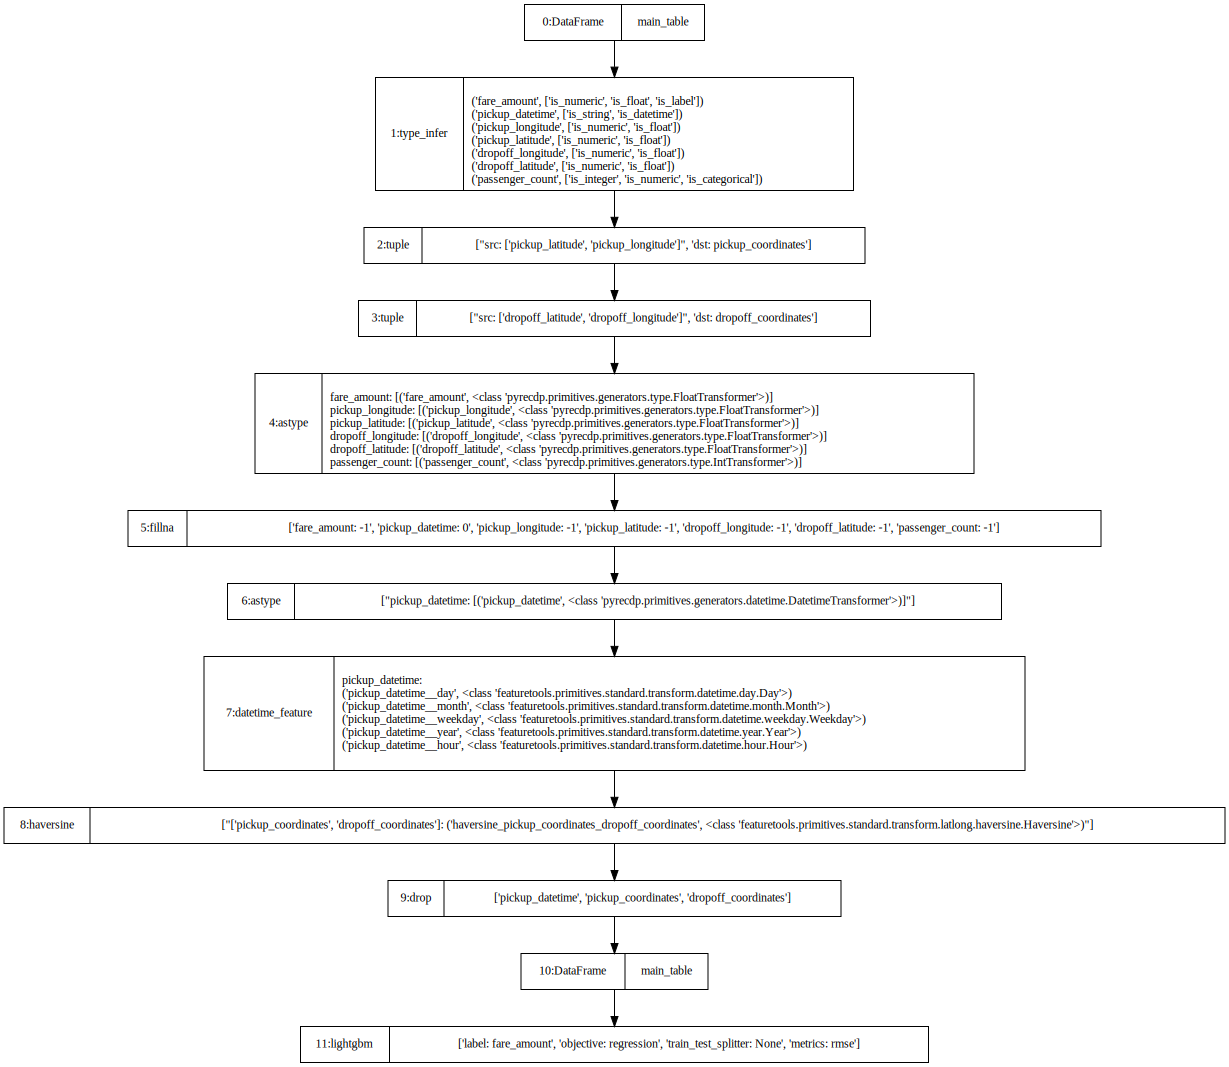

In [6]:
pipeline.plot()